# XGBoost

Training model to predict whether patient dies, or not.

1) binary model (dead, not dead)
2) multi-class classification model and using just the mRS6 classification outcome

## Import libraries

In [239]:
# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import scipy

from xgboost import XGBClassifier
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

import json

from dataclasses import dataclass

import seaborn as sns

from sklearn.metrics import roc_auc_score

from sklearn.metrics import confusion_matrix

from matplotlib.lines import Line2D

import pickle
import shap

from os.path import exists

import math

from sklearn.metrics import accuracy_score

import importlib
# Import local package
from utils import waterfall
# Force package to be reloaded
importlib.reload(waterfall);

import time

Report the time duration to run notebook

In [240]:
start_time = time.time()

## Set up paths and filenames

In [241]:
@dataclass(frozen=True)
class Paths:
    '''Singleton object for storing paths to data and database.'''

  #  data_path: str = '../'
  #  data_filename: str = 'SAMueL ssnap extract v2.csv'
  #  data_save_path: str = './'
  #  data_save_filename: str = 'reformatted_data.csv'
  #  database_filename: str = 'samuel.db'
  #  notebook: str = '01'
  #  kfold_folder: str = 'data/kfold_5fold/'

    data_read_path: str = '../data/'
    data_read_filename: str = '02_reformatted_data_ml_230612.csv'
 #   data_save_path: str = './kfold_5fold'
#    data_save_filename: str = 'train.csv'
    notebook: str = '230725_'
    model_text: str = 'xgb_all_data_binary'

paths = Paths()

## Import data

Data has previously been split into 5 stratified k-fold splits.

In [242]:
filename = paths.data_read_path + paths.data_read_filename
data = pd.read_csv(filename)

In [243]:
class_names = data['discharge_disability'].unique()
class_names = np.sort(class_names)
n_classes = len(class_names)

Want to use onset to thrombolysis time in the model. Define function to calculate the feature.

In [244]:
def calculate_onset_to_thrombolysis(row):
    # Set default value of onset to thrombolysis of -100 (no thrombolysis given)
    onset_to_thrombolysis = -100
    # Set value if thrombolysis given
    if  row['scan_to_thrombolysis_time'] != -100:
        onset_to_thrombolysis = (row['onset_to_arrival_time'] + 
        row['arrival_to_scan_time'] + row['scan_to_thrombolysis_time'])
    return onset_to_thrombolysis

In [245]:
# Calculate onset to thgrombolysis (but set to -100 if no thrombolysis given)
data['onset_to_thrombolysis_time'] = data.apply(calculate_onset_to_thrombolysis, axis=1)
data.drop(['scan_to_thrombolysis_time', 'arrival_to_scan_time',
        'onset_to_arrival_time'], axis=1, inplace=True)

Get list of features

In [246]:
features = list(data)
print(f"There are {len(features)} features")

There are 54 features


Calculate the binary outcome: Dead or not dead

In [247]:
data["discharge_mrs6"] = 0
mask = data["discharge_disability"] == 6
data["discharge_mrs6"][mask] = 1

In [248]:
selected_features = ['prior_disability','stroke_severity','stroke_team',
                     'onset_to_thrombolysis_time','age']
X_data = data[selected_features]

In [249]:
y_data_mc = data['discharge_disability']
y_data_bin = data['discharge_mrs6']

## One hot the categorical features

Convert some categorical features to one hot encoded features.

Define a function

In [250]:
def convert_feature_to_one_hot(df, feature_name, prefix):
    """
    df [dataframe]: training or test dataset
    feature_name [str]: feature to convert to ont hot encoding
    prefix [str]: string to use on new feature
    """

    # One hot encode a feature
    df_feature = pd.get_dummies(
        df[feature_name], prefix = prefix)
    df = pd.concat([df, df_feature], axis=1)
    df.drop(feature_name, axis=1, inplace=True)

    return(df)

Set up two lists for the one hot encoding. 

A list of the feature names that are categorical and to be converted using one hot encoding.
A list of the prefixes to use for these features.

In [251]:
features_to_one_hot = ["stroke_team"]
list_prefix = ["team"]

In [252]:
for feature, prefix in zip(features_to_one_hot, list_prefix):
    X_data = convert_feature_to_one_hot(X_data, feature, prefix)

Get list of features in dataset, post one hot encoding.

In [253]:
features_ohe = list(X_data)

## Fit XGBoost model (binary death)

Train model with all data

In [254]:
filename = f"{paths.notebook}{paths.model_text}_bin.p"

# Check if exists
file_exists = exists(filename)

if file_exists:
    # load model
    with open(filename, 'rb') as filehandler:
        model = pickle.load(filehandler)
else:        

    # Define model
    model_bin = XGBClassifier(verbosity = 0, seed=42, learning_rate=0.5)

    # Fit model
    model_bin.fit(X_data, y_data_bin)

    # Save model
    with open(filename, 'wb') as filehandler:
        pickle.dump(model_bin, filehandler)

# Get predicted probabilities
y_probs_bin = model_bin.predict_proba(X_data)
y_pred_bin = model_bin.predict(X_data)

# Calculate error
y_error_bin = y_data_bin - y_pred_bin

Show accuracy (identity)

In [255]:
accuracy = np.mean(y_error_bin==0)
print (f'Accuracy (binary model): {accuracy:0.2f}')

Accuracy (binary model): 0.90


Given so few die, a model classifying all as alive gives this accuracy:

In [256]:
y_data_bin.value_counts()

0    137271
1     19576
Name: discharge_mrs6, dtype: int64

In [257]:
y_data_bin.value_counts()[0]/y_data_bin.shape[0]

0.8751904722436514

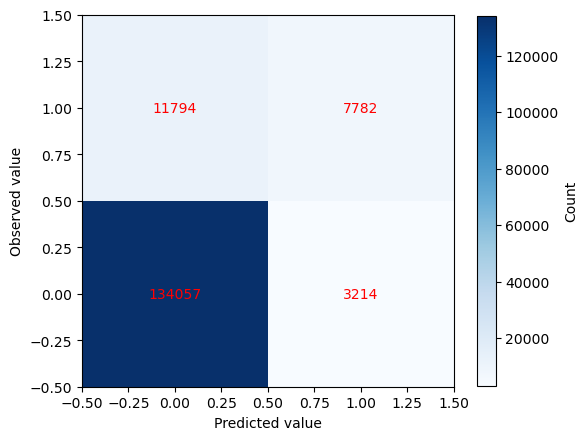

In [258]:
# Show confusion matrix
cm = confusion_matrix(y_data_bin, y_pred_bin)

# Visualize the confusion matrix with colors
fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(1,1,1)
heatmap = plt.imshow(cm, cmap=plt.cm.Blues, origin='lower')
colorbar = plt.colorbar(heatmap, shrink=0.8, ax=ax1, alpha=0.5, label='Count')

# To add values to plot
for i in range(len(cm)):
    for j in range(len(cm[0])):
        plt.text(j, i, cm[i][j], ha='center', va='center', color='r')

ax1.set_xlabel('Predicted value')
ax1.set_ylabel('Observed value')
plt.show()

## Receiver Operator Characteristic and Sensitivity-Specificity Curves

### Receiver Operator Characteristic Curve:

In [259]:
fpr, tpr, thresholds = roc_curve(y_data_bin, y_probs_bin[:,1])
roc_auc = auc(fpr, tpr)

# Show area under curve  
print (f'\nAUC: {roc_auc:0.4f}')


AUC: 0.8914


Calculate data for sensitivity-specificity curve:

In [260]:
def calculate_accuracy(observed, predicted):
    
    """
    Calculates a range of accuracy scores from observed and predicted classes.
    
    Takes two list or NumPy arrays (observed class values, and predicted class 
    values), and returns a dictionary of results.
    
     9) sensitivity: Same as recall
    10) specificity: Proportion of true -ve identified:        
    """
    
    # Converts list to NumPy arrays
    if type(observed) == list:
        observed = np.array(observed)
    if type(predicted) == list:
        predicted = np.array(predicted)
    
    # Calculate accuracy scores
    observed_positives = observed == 1
    observed_negatives = observed == 0
    predicted_positives = predicted == 1
    predicted_negatives = predicted == 0
    
    true_positives = (predicted_positives == 1) & (observed_positives == 1)
    
    false_positives = (predicted_positives == 1) & (observed_positives == 0)

    true_negatives = (predicted_negatives == 1) & (observed_negatives == 1)
    
    false_negatives = (predicted_negatives == 1) & (observed_negatives == 0)
       
    sensitivity = np.sum(true_positives) / np.sum(observed_positives)
    
    specificity = np.sum(true_negatives) / np.sum(observed_negatives)
    
    
    # Create dictionary for results, and add results
    results = dict()
    
    results['sensitivity'] = sensitivity
    results['specificity'] = specificity
    
    return results

In [261]:
sensitivity = []
specificity = []

# Get classification probabilities for k-fold replicate
observed = y_data_bin
proba = y_probs_bin[:,1]

# Loop through increments in probability of survival
thresholds = np.arange(0.0, 1.01, 0.01)
for cutoff in thresholds: #  loop 0 --> 1 on steps of 0.1
    # Get classificiation using cutoff
    predicted_class = proba >= cutoff
    predicted_class = predicted_class * 1.0
    # Call accuracy measures function
    accuracy = calculate_accuracy(observed, predicted_class)
    # Add accuracy scores to lists
    sensitivity.append(accuracy['sensitivity'])
    specificity.append(accuracy['specificity'])

Create a combined plot: ROC and sensitivity-specificity

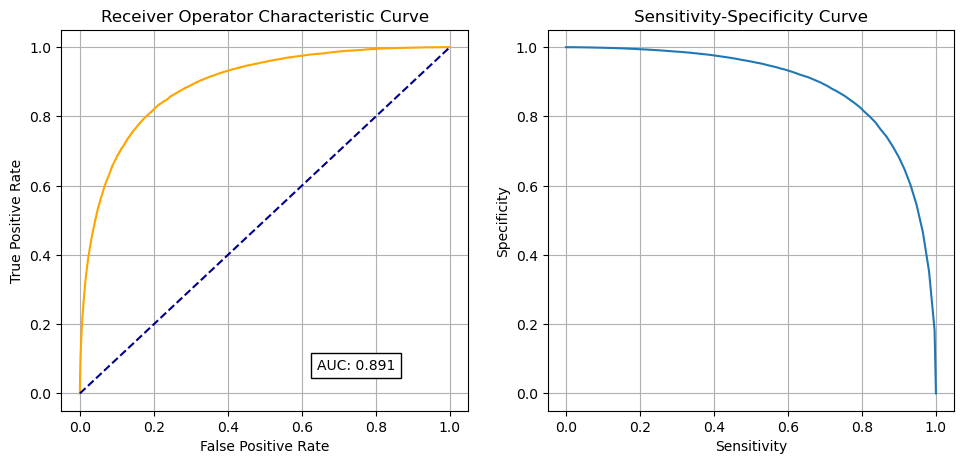

In [262]:
fig = plt.figure(figsize=(10,5))

# Plot ROC
ax1 = fig.add_subplot(121)
ax1.plot(fpr, tpr, color='orange')
ax1.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('Receiver Operator Characteristic Curve')
text = f'AUC: {roc_auc:.3f}'
ax1.text(0.64,0.07, text, 
         bbox=dict(facecolor='white', edgecolor='black'))
plt.grid(True)

# Plot sensitivity-specificity
ax2 = fig.add_subplot(122)
ax2.plot(sensitivity, specificity)
ax2.set_xlabel('Sensitivity')
ax2.set_ylabel('Specificity')
ax2.set_title('Sensitivity-Specificity Curve')
plt.grid(True)


plt.tight_layout(pad=2)
filename = f"{paths.notebook}{paths.model_text}_bin_roc_sens_spec.jpg"
plt.savefig(filename, dpi=300)

plt.show()

Identify cross-over point on sensitivity-specificity curve
Adjusting the classification threshold allows us to balance sensitivity (the proportion of patients receiving thrombolysis correctly identified) and specificity (the proportion of patients not receiving thrombolysis correctly identified). An increase in sensitivity causes a loss in specificity (and vice versa). Here we identify the pint where specificity and sensitivity hold the same value.

In [263]:
def get_intersect(a1, a2, b1, b2):
    """ 
    Returns the point of intersection of the lines passing through a2,a1 and 
    b2,b1.
    
    a1: [x, y] a point on the first line
    a2: [x, y] another point on the first line
    b1: [x, y] a point on the second line
    b2: [x, y] another point on the second line
    """
    s = np.vstack([a1,a2,b1,b2])        # s for stacked
    h = np.hstack((s, np.ones((4, 1)))) # h for homogeneous
    l1 = np.cross(h[0], h[1])           # get first line
    l2 = np.cross(h[2], h[3])           # get second line
    x, y, z = np.cross(l1, l2)          # point of intersection
    if z == 0:                          # lines are parallel
        return (float('inf'), float('inf'))
    return (x/z, y/z)

In [264]:
df = pd.DataFrame()
df['sensitivity'] = np.array(sensitivity)
df['specificity'] = np.array(specificity)
df['spec greater sens'] = df['specificity'] > df['sensitivity']

# find last index for senitivity being greater than specificity 
mask = df['spec greater sens'] == False
last_id_sens_greater_spec = np.max(df[mask].index)
locs = [last_id_sens_greater_spec, last_id_sens_greater_spec + 1]
points = df.iloc[locs][['sensitivity', 'specificity']]

# Get intersetction with line of x=y
a1 = list(points.iloc[0].values)
a2 = list(points.iloc[1].values)
b1 = [0, 0]
b2 = [1, 1]

intersection = get_intersect(a1, a2, b1, b2)[0]

print (f'\nIntersection: {intersection:0.4f}')


Intersection: 0.8102


Confusion matrix with this threshold

In [265]:
y_pred_bin = y_probs_bin[:,1] > intersection

y_error_bin = y_data_bin - y_pred_bin

accuracy = np.mean(y_error_bin==0)
print (f'Accuracy (binary) [intersect threshold {intersection:0.4f}]: {accuracy:0.4f}')

Accuracy (binary) [intersect threshold 0.810185414019405]: 0.88


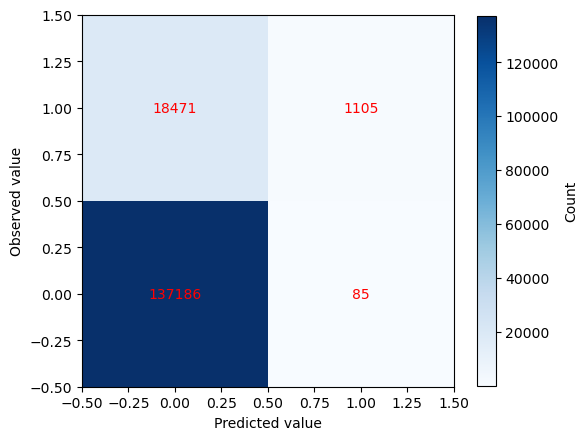

In [266]:
# Show confusion matrix
cm = confusion_matrix(y_data_bin, y_pred_bin)

# Visualize the confusion matrix with colors
fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(1,1,1)
heatmap = plt.imshow(cm, cmap=plt.cm.Blues, origin='lower')
colorbar = plt.colorbar(heatmap, shrink=0.8, ax=ax1, alpha=0.5, label='Count')

# To add values to plot
for i in range(len(cm)):
    for j in range(len(cm[0])):
        plt.text(j, i, cm[i][j], ha='center', va='center', color='r')

ax1.set_xlabel('Predicted value')
ax1.set_ylabel('Observed value')
plt.show()

## Fit XGBoost model (multiclass model, analysing performance for predicting death [outcome 6])

Train model with all data

In [267]:
filename = f"{paths.notebook}{paths.model_text}_mc.p"

# Check if exists
file_exists = exists(filename)

if file_exists:
    # load model
    with open(filename, 'rb') as filehandler:
        model_mc = pickle.load(filehandler)
else:        

    # Define model
    model_mc = XGBClassifier(verbosity = 0, seed=42, learning_rate=0.5)

    # Fit model
    model_mc.fit(X_data, y_data_mc)

    # Save model
    with open(filename, 'wb') as filehandler:
        pickle.dump(model_mc, filehandler)

# Get predicted probabilities
y_probs_mc = model_mc.predict_proba(X_data)
y_pred_mc = model_mc.predict(X_data)

Get just the probability for death (outcome 6)

In [268]:
y_pred_mc_6 = y_probs_mc[:,6] > 0.5

#y_data_mc_6 = (y_data_mc == 6) * 1

y_error_mc_6 = y_data_bin - y_pred_mc_6

accuracy = np.mean(y_error_mc_6==0)
print (f'Accuracy (multiclass) [default threshold]: {accuracy:0.2f}')

Accuracy (multiclass) [default threshold]: 0.90


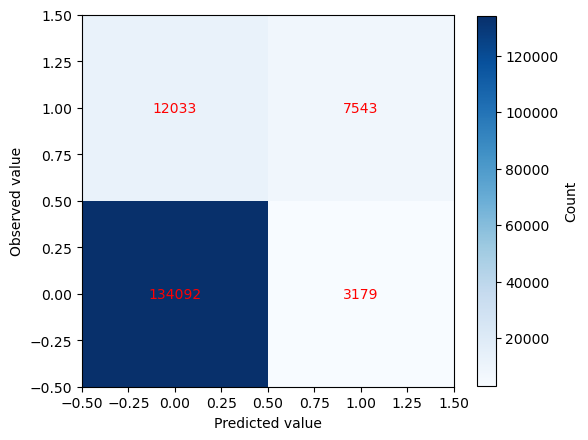

In [269]:
# Show confusion matrix
cm = confusion_matrix(y_data_bin, y_pred_mc_6)

# Visualize the confusion matrix with colors
fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(1,1,1)
heatmap = plt.imshow(cm, cmap=plt.cm.Blues, origin='lower')
colorbar = plt.colorbar(heatmap, shrink=0.8, ax=ax1, alpha=0.5, label='Count')

# To add values to plot
for i in range(len(cm)):
    for j in range(len(cm[0])):
        plt.text(j, i, cm[i][j], ha='center', va='center', color='r')

ax1.set_xlabel('Predicted value')
ax1.set_ylabel('Observed value')
plt.show()

ROC AUC

In [270]:
fpr, tpr, thresholds = roc_curve(y_data_bin, y_probs_mc[:,6])
roc_auc = auc(fpr, tpr)

# Show area under curve  
print (f'\nAUC: {roc_auc:0.4f}')


AUC: 0.8891


In [271]:
sensitivity = []
specificity = []

# Get classification probabilities for k-fold replicate
observed = y_data_bin
proba = y_probs_mc[:,6]

# Loop through increments in probability of survival
thresholds = np.arange(0.0, 1.01, 0.01)
for cutoff in thresholds: #  loop 0 --> 1 on steps of 0.1
    # Get classificiation using cutoff
    predicted_class = proba >= cutoff
    predicted_class = predicted_class * 1.0
    # Call accuracy measures function
    accuracy = calculate_accuracy(observed, predicted_class)
    # Add accuracy scores to lists
    sensitivity.append(accuracy['sensitivity'])
    specificity.append(accuracy['specificity'])

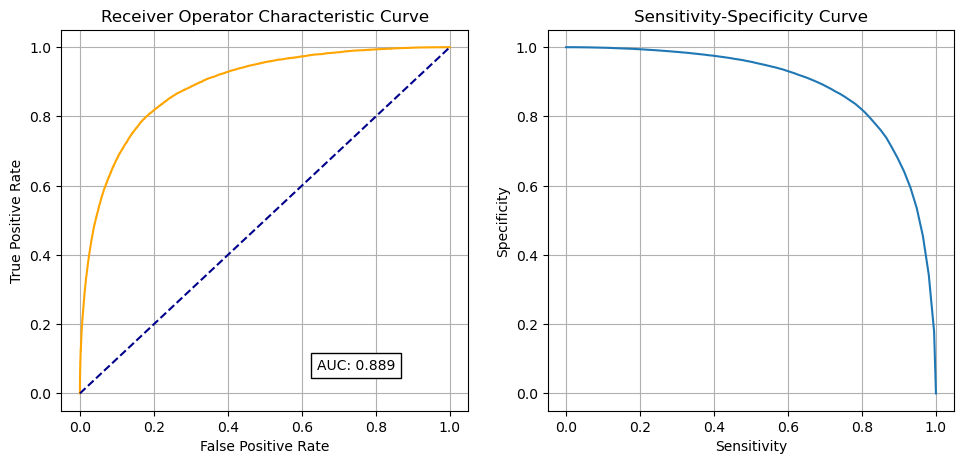

In [272]:
fig = plt.figure(figsize=(10,5))

# Plot ROC
ax1 = fig.add_subplot(121)
ax1.plot(fpr, tpr, color='orange')
ax1.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('Receiver Operator Characteristic Curve')
text = f'AUC: {roc_auc:.3f}'
ax1.text(0.64,0.07, text, 
         bbox=dict(facecolor='white', edgecolor='black'))
plt.grid(True)

# Plot sensitivity-specificity
ax2 = fig.add_subplot(122)
ax2.plot(sensitivity, specificity)
ax2.set_xlabel('Sensitivity')
ax2.set_ylabel('Specificity')
ax2.set_title('Sensitivity-Specificity Curve')
plt.grid(True)


plt.tight_layout(pad=2)
filename = f"{paths.notebook}{paths.model_text}_mc_roc_sens_spec.jpg"
plt.savefig(filename, dpi=300)

plt.show()

In [273]:
df = pd.DataFrame()
df['sensitivity'] = np.array(sensitivity)
df['specificity'] = np.array(specificity)
df['spec greater sens'] = df['specificity'] > df['sensitivity']

# find last index for senitivity being greater than specificity 
mask = df['spec greater sens'] == False
last_id_sens_greater_spec = np.max(df[mask].index)
locs = [last_id_sens_greater_spec, last_id_sens_greater_spec + 1]
points = df.iloc[locs][['sensitivity', 'specificity']]

# Get intersetction with line of x=y
a1 = list(points.iloc[0].values)
a2 = list(points.iloc[1].values)
b1 = [0, 0]
b2 = [1, 1]

intersection = get_intersect(a1, a2, b1, b2)[0]

print (f'\nIntersection: {intersection:0.4f}')


Intersection: 0.8098


Confusion matrix with this threshold

In [274]:
y_pred_mc_6 = y_probs_mc[:,6] > intersection
y_error_mc_6 = y_data_bin - y_pred_mc_6

accuracy = np.mean(y_error_mc_6==0)
print (f'Accuracy (multiclass) [intersect threshold {intersection:0.4f}]: {accuracy:0.4f}')

Accuracy (multiclass) [intersect threshold 0.8097724394748046]: 0.88


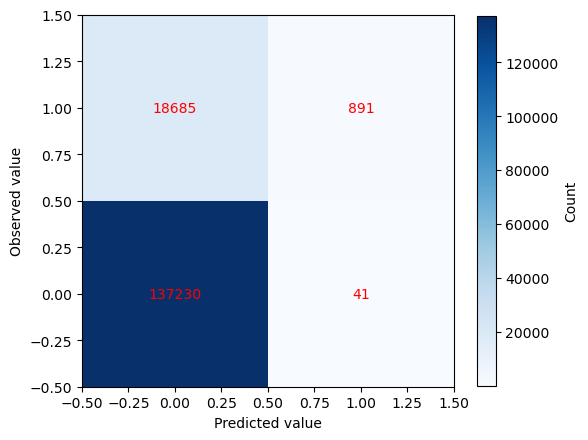

In [275]:
# Show confusion matrix
cm = confusion_matrix(y_data_bin, y_pred_mc_6)

# Visualize the confusion matrix with colors
fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(1,1,1)
heatmap = plt.imshow(cm, cmap=plt.cm.Blues, origin='lower')
colorbar = plt.colorbar(heatmap, shrink=0.8, ax=ax1, alpha=0.5, label='Count')

# To add values to plot
for i in range(len(cm)):
    for j in range(len(cm[0])):
        plt.text(j, i, cm[i][j], ha='center', va='center', color='r')

ax1.set_xlabel('Predicted value')
ax1.set_ylabel('Observed value')
plt.show()

In [276]:
end_time = time.time()

print(f'Time taken: {end_time - start_time}')

Time taken: 5.7928760051727295
